<a href="https://colab.research.google.com/github/hyeonjunchoi/Towel-Folding-Robot/blob/main/ResNet_Based_Camera_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import time

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics    import classification_report, accuracy_score
from IPython.display    import Markdown, display
from keras.src.legacy.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [ ]:
print(tf.__version__)

2.17.1


In [ ]:
dir_ = Path(r'/content/drive/MyDrive/Training')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split(os.path.sep)[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    #경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    #index 재설정
    df = df.sample(frac=1, random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 4349

Number of different labels: 8

Labels: ['cat' 'person' 'motorbike' 'fruit' 'cars' 'towel' 'bath_data' 'flower']


In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    #model(**kwargs)는 kwargs 내부의 인수가 pretrained_model에 대응되어 들어간다 라는 것을 의미
    #위의 line은 input shape를 정의해준다.
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input
    #pretrained_model의 input shape에 맞는 input이 들어간다.

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    # 위의 과정을 통해, outputs이 결정된다.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    #model.compile을 통해, Loss가 반영되고, 학습이 진행된다.

    return model

Found 3523 validated image filenames belonging to 8 classes.
Found 391 validated image filenames belonging to 8 classes.
Found 435 validated image filenames belonging to 7 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 2130s 18s/step - accuracy: 0.9180 - loss: 0.2891 - val_accuracy: 0.9974 - val_loss: 0.0097
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.9992 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 4.5857e-04
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 313ms/step - accuracy: 1.0000 - loss: 2.4905e-04 - val_accuracy: 1.0000 - val_loss: 6.7160e-04
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 286ms/step - accuracy: 1.0000 - loss: 2.1459e-04 - val_accuracy: 1.0000 - val_loss: 4.7314e-04
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 290ms/step - accuracy: 1.0000 - loss: 5.9539e-05 - val_accuracy: 1.0000 - val_loss: 4.5590e-04


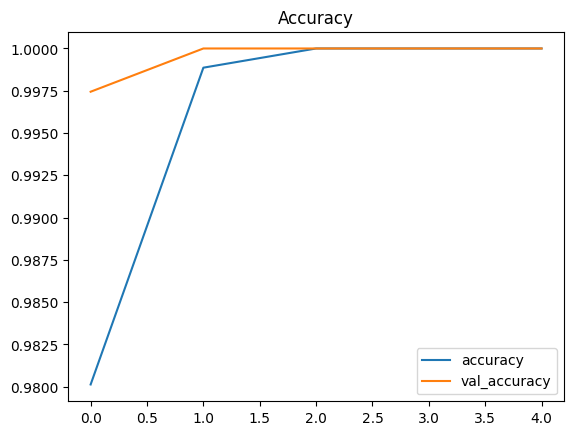

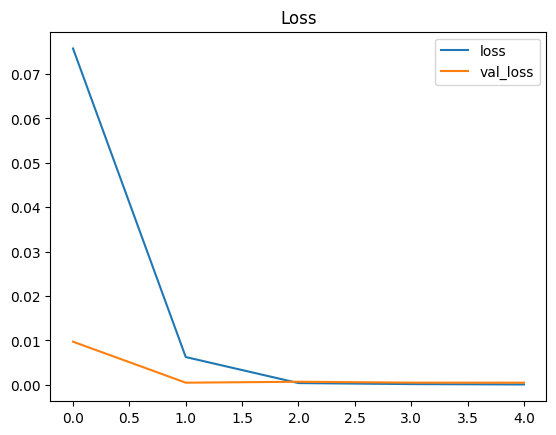

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 253s 19s/step


# Accuracy on the test set: 99.77%

In [ ]:
#ResNet으로 실험진행


train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
#위에서 가져온 df를 trainset과 testset으로 나눠준다.
train_generator,test_generator,train_images,val_images,test_images=create_gen()
#create_gen() 함수의 결과로 나온 값을 불러온다.

model = get_model(tf.keras.applications.ResNet152V2)
#위에서 정의한 get_model()함수에 ResNet152V2를 넣어주고, 반환값을 model에 넣는다.
history = model.fit(train_images,validation_data=val_images,epochs=5)
#input으로 train_images, val_images를 위에서 선정된 Model에 넣어주고, 모델훈련을 한 뒤, 결과를 history에 지정한다.

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
#history의 결과로 도출된 Accuracy를 그래프로 표현한다.

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
#history의 결과로 도출된 Loss를 그래프로 표현한다.

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Immediately capture without waiting for button click
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def convert_to_png(jpeg_filename, png_filename):
    # Open the JPEG image
    with Image.open(jpeg_filename) as img:
        # Convert and save as PNG
        img.save(png_filename, 'PNG')
    return png_filename

# Capture photo and convert to PNG
def takephoto():
  jpeg_photo = take_photo()
  png_photo = convert_to_png(jpeg_photo, 'photo.png')
  camera_image = cv2.imread(png_photo)
  return camera_image

In [ ]:
IMAGE_SIZE = (224, 224)

timeout = 3 * 60

start_time = time.time()

while True:

  camera_image = takephoto()
  #camera_image = capture_image_from_camera()

  camera_image = cv2.resize(camera_image, IMAGE_SIZE)
  camera_image = camera_image.reshape((1, camera_image.shape[0], camera_image.shape[1], camera_image.shape[2]))
  camera_image = preprocess_input(camera_image)

  pred = model.predict(camera_image)
  pred = np.argmax(pred,axis=1)
  labels = (train_images.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  pred = [labels[k] for k in pred]
  print(pred)

  if pred[0] == 'towel':
    print('Its towel')
    break

  elapsed_time = time.time() - start_time

  if elapsed_time >= timeout:
    print('Time out')
    break

  time.sleep(1)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
['person']


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
['towel']
Its towel
